# ROBERTA fastai Multi-Label Classification


In [ ]:
#import transformers
! pip install transformers -q

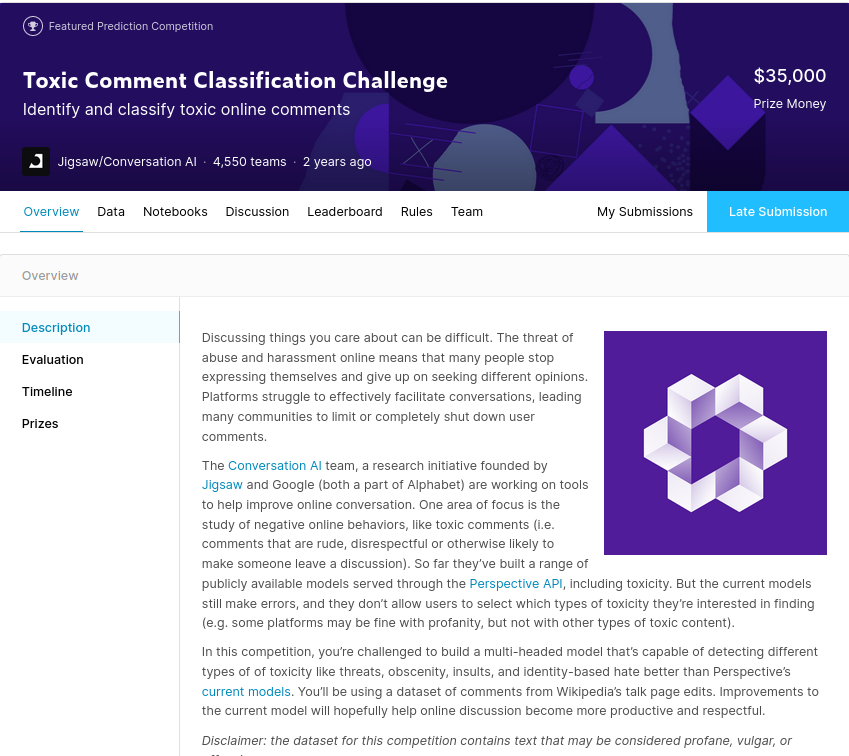

In [4]:
from IPython.display import Image
Datapath = Path('/home/wyquek/Documents/Kaggle/Toxic Comment Classification Challenge')
Image(Datapath/"Image/ToxicCommentOverview.png")

In [2]:
import csv
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim
from sklearn.metrics import classification_report, f1_score , recall_score, precision_score
from sklearn.model_selection import train_test_split

from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

In [2]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,
    seed = 2019,
    roberta_model_name='roberta-base',
    max_lr=1e-5,
    epochs=1,
    use_fp16=False,
    bs=64, 
    max_seq_len= 128, 
    num_labels = 6,
    hidden_dropout_prob=.05,
    hidden_size=768, 
)

In [3]:
class FastAiTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        tokens = [CLS] + tokens + [SEP]
        return tokens
    

tok = RobertaTokenizer.from_pretrained(config.roberta_model_name,)
fastai_tokenizer = Tokenizer(tok_func=FastAiTokenizer(tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [4]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: RobertaTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})


In [5]:
fastai_vocab = TransformersVocab(tok)

In [6]:
Datapath = Path("../input/jigsaw-toxic-comment-classification-challenge")
#Datapath = Path('/home/wyquek/Documents/Kaggle/Toxic Comment Classification Challenge')

In [7]:
#train = pd.read_csv(Datapath/"train.csv")
train = pd.read_csv(Datapath/"train.csv.zip")
train.head() 

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
#test = pd.read_csv(Datapath/"test.csv")
test = pd.read_csv(Datapath/"test.csv.zip")
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
X_train, X_val = train_test_split(train,test_size = 0.3)
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
pad_idx = tok.pad_token_id
databunch = TextDataBunch.from_df(".",  # 
                    train_df = X_train, 
                    valid_df = X_val,
                    test_df = test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_vocab,
                  text_cols="comment_text",
                  label_cols= label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=pad_idx),)

In [10]:
from transformers import RobertaModel
# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=6):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels) # defining final output layer
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) # 
        logits = self.classifier(pooled_output)        
        return logits

In [11]:
roberta_model = CustomRobertaModel(num_labels=6)

In [12]:
config.use_fp16 = True

In [13]:
loss_func = nn.BCEWithLogitsLoss()
learner = Learner(databunch, roberta_model,loss_func=loss_func,)
if config.use_fp16: learner = learner.to_fp16()

In [14]:
learner.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


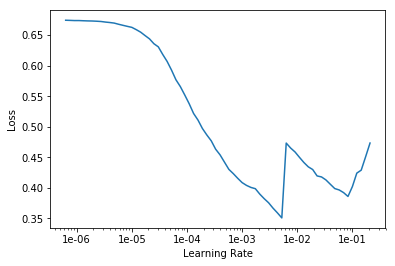

In [15]:
learner.recorder.plot()

In [16]:
learner.fit_one_cycle(2, slice(1e-4))

epoch,train_loss,valid_loss,time
0,0.050291,0.050658,14:17
1,0.039871,0.040914,16:40


In [20]:
learner.save("model")

In [23]:
learner.unfreeze()
learner.lr_find(start_lr = 1e-10)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.41E-09
Min loss divided by 10: 4.07E-06


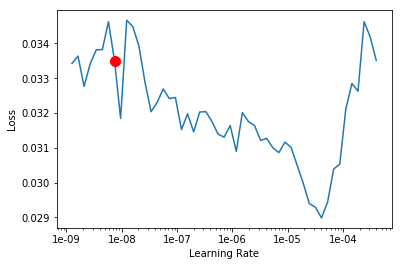

In [24]:
learner.recorder.plot(suggestion=True)

In [25]:
learner.fit_one_cycle(4, slice(1e-5))

epoch,train_loss,valid_loss,time
0,0.034522,0.041733,16:40
1,0.032541,0.039940,14:57
2,0.024883,0.041395,14:07
3,0.026842,0.041369,15:53


In [26]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    #return np.argmax(preds[reverse_sampler, :], axis = 1)
    return preds[reverse_sampler, :]

# val_preds = get_preds_as_nparray(DatasetType.Valid)
test_preds = get_preds_as_nparray(DatasetType.Test)

In [27]:
#sample_submission = pd.read_csv(Datapath / "sample_submission.csv")
sample_submission = pd.read_csv(Datapath / "sample_submission.csv.zip")
#if config.testing: 
sample_submission = sample_submission.head(test.shape[0])
sample_submission[label_cols] = test_preds
sample_submission.to_csv("predictions_roberta_fastai_trained_on_kaggle_unfreeze.csv", index=False)

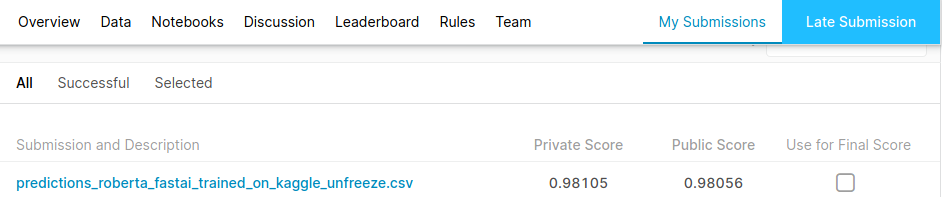

In [5]:
Image(Datapath/"Image/score.png")

`Transformer ROBERTA-pretrained`
`fastai DataBunch`
`1 frozen epochs, 4 unfreeze epochs`
`1 GPU on Kaggle`

Roberta_fastai_toxic_comments2_unfreezed_on_kaggle

Reference : [ BERT with fastai notebook on Jigsaw Toxic Comments by keitakurita](https://github.com/keitakurita/Practical_NLP_in_PyTorch/blob/master/fastai/bert_with_fastai.ipynb).